# INICIALIZAÇÃO

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_score,  recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score

#Criando os modelos
logit = LogisticRegression(solver='lbfgs', max_iter=400)
knn = KNeighborsClassifier(n_neighbors=1)
dtree = DecisionTreeClassifier()
ada = AdaBoostClassifier(n_estimators=10, learning_rate=0.4, random_state=0)

#Dados rotulados que serão usados para treinamento e teste dos modelos
dadosGerais = pd.read_csv("train.csv")

#Dados que serão rotulados
testeFinal = pd.read_csv("test.csv")

In [219]:
#Função para mensurar a raiz quadrada do erro médio dos modelos com validação cruzada
def rmse_cv(model,x_treino,y_treino):
    rmse= np.sqrt(-cross_val_score(model, x_treino, y_treino, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

# 1- VERIFICANDO DESBALANCEAMENTO

In [220]:
quantidadeDeTiposDeValores = len(np.unique(dadosGerais['situacao']))
quantidadeDeCadaValor = dadosGerais['situacao'].value_counts()
totalDeValores = sum(quantidadeDeCadaValor)
porcentagens = []
for i in range(1,quantidadeDeTiposDeValores+1):
    porcentagens.append(quantidadeDeCadaValor[i-1]/totalDeValores)
print(quantidadeDeCadaValor)
print('Porcentagens da cada valor:', porcentagens)

nao_eleito    6596
eleito        1026
Name: situacao, dtype: int64
Porcentagens da cada valor: [0.8653896615061664, 0.13461033849383364]


### Como pode ser observado, a quantidade instâncias 'nao_eleito' é muito maior que 'eleito', logo os dados estão desbalanceados. 
### O desbalanceamento dos dados pode produzir efeitos colaterais, tais como fazer com que o classificador generalize todas as instâncias como pertencentes a classe majoritária, visando apenas um alto nível de acerto.
### Para tratar o desbalanceamento dos dados eu realizaria um Undersampling da classe majoritária por meio de algoritmos de clusterização, tais como KNN, no intuito de reduzir a quantidade de instâncias e possível redundância ou ruídos dos dados.

# 2- TREINAMENTOS

### Pré-processamento

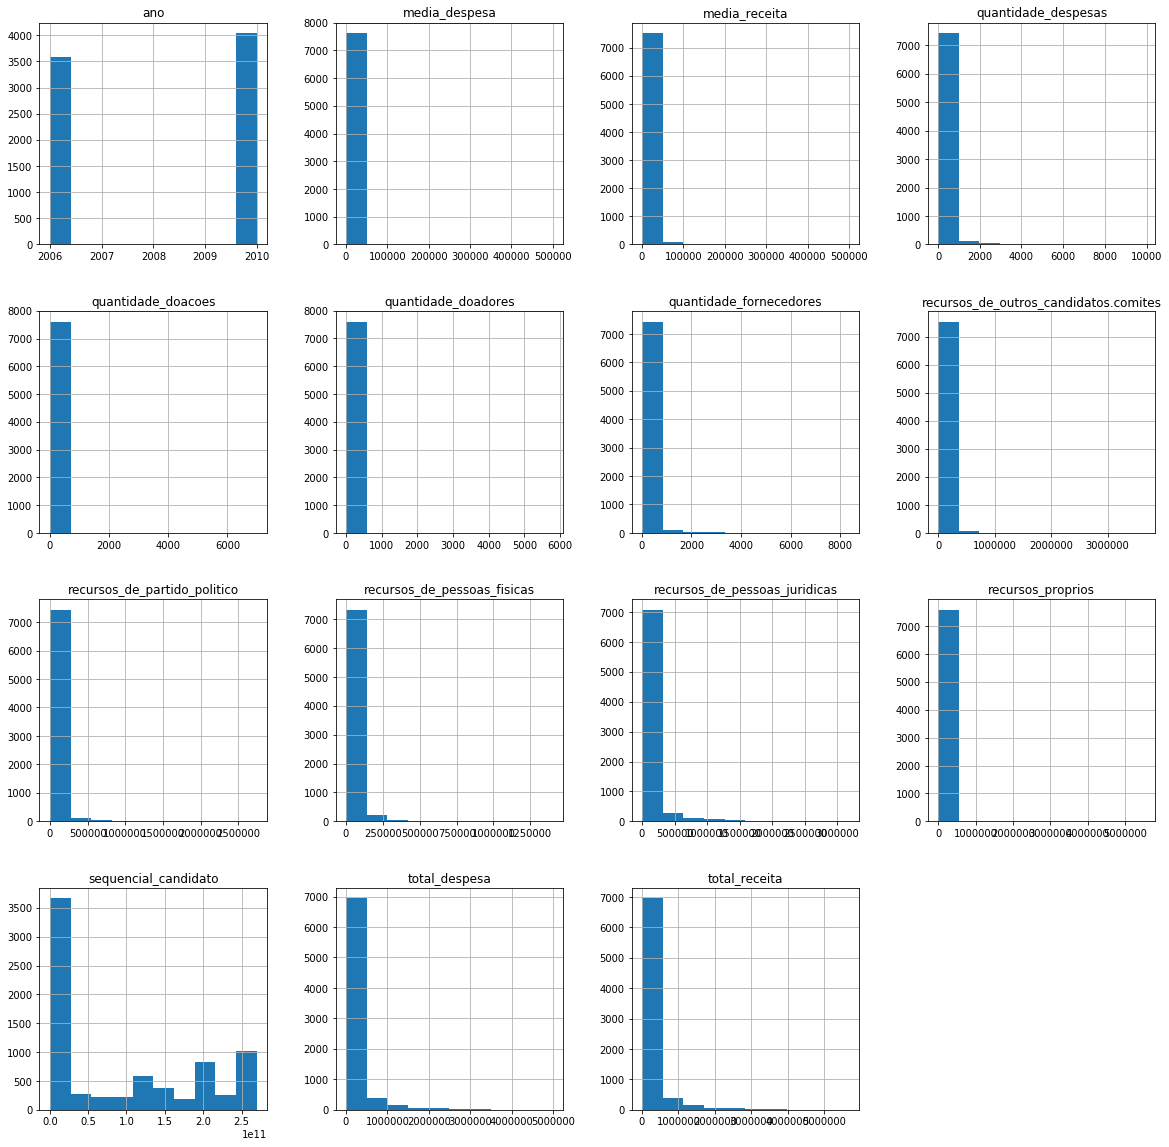

In [221]:
#Analise por meio de histogramas o enviesamento da variável 'votos' com relação ao log+1 dela 
dadosGerais[dadosGerais.dtypes[dadosGerais.dtypes != "object"].index].hist(bins=10, figsize=(20, 20))
plt.show()

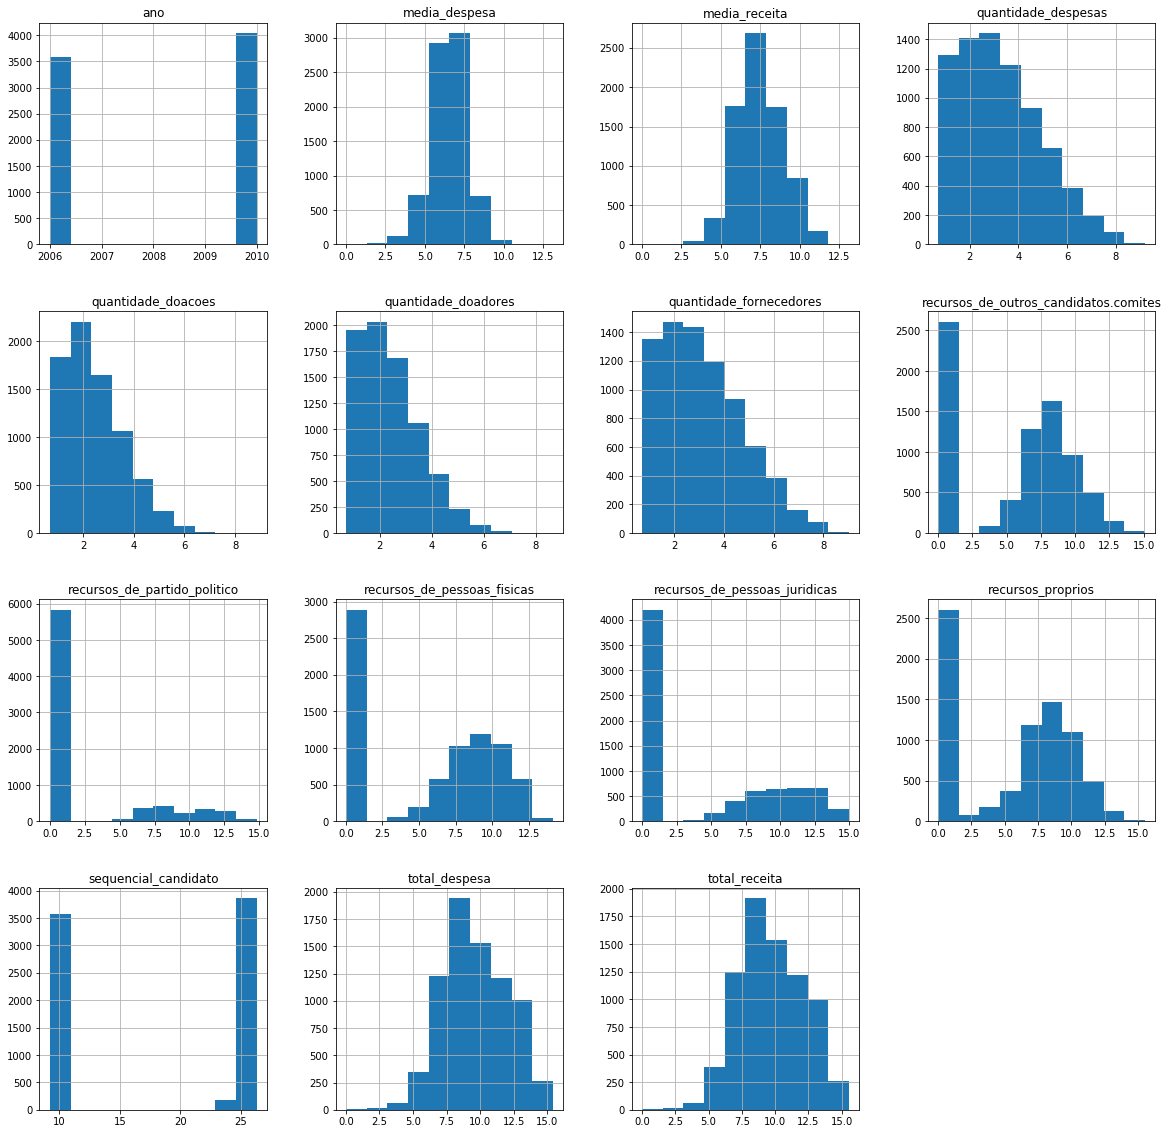

In [222]:
#Nesse momento, todos as variáveis são atualizadas pelo log+1 delas com relação ao nível de skewness delas
numeric_feats = dadosGerais.dtypes[dadosGerais.dtypes != "object"].index

skewed_feats = dadosGerais[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats.index
skewed_feats = skewed_feats[1:]

dadosGerais[skewed_feats] = np.log1p(dadosGerais[skewed_feats])

#Também realizado no novo conjunto de teste final
numeric_feats = testeFinal.dtypes[testeFinal.dtypes != "object"].index

skewed_feats = testeFinal[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats.index
skewed_feats = skewed_feats[1:]

teste[skewed_feats] = np.log1p(testeFinal[skewed_feats])

#Exibição dados de treino
dadosGerais[dadosGerais.dtypes[dadosGerais.dtypes != "object"].index].hist(bins=10, figsize=(20, 20))
plt.show()

In [223]:
#removendo colunas 'nomes', 'cargo', 'ano' e 'sequencial_candidato' para reduzir dimensões da matriz e por considerar que não são influenciadores
dadosGerais = dadosGerais.drop(["nome"],axis=1)
dadosGerais = dadosGerais.drop(["cargo"],axis=1)
dadosGerais = dadosGerais.drop(["sequencial_candidato"],axis=1)
dadosGerais = dadosGerais.drop(["ano"],axis=1)

testeFinal = testeFinal.drop(["nome"],axis=1)
testeFinal = testeFinal.drop(["cargo"],axis=1)
testeFinal = testeFinal.drop(["ano"],axis=1)

#Alterando variáveis categóricas
dadosGerais['situacao'] = np.where(dadosGerais['situacao']=='eleito', 1,0)

dadosGerais = pd.get_dummies(dadosGerais)
testeFinal = pd.get_dummies(testeFinal)

#Preechendo "NAs" com as médias de suas respectivas variáveis
dadosGerais = dadosGerais.fillna(dadosGerais.mean())
testeFinal = testeFinal.fillna(testeFinal.mean())

#Organizando vetores X e Y
X = dadosGerais.drop(["situacao"],axis=1)
Y = dadosGerais["situacao"]

#Igualando as colunas no conjunto teste
diferençaColunas = (set(dadosGerais.columns) - (set(testeFinal.columns)))
diferençaColunas.remove('situacao');
zeros = [0]*len(diferençaColunas);
novoTesteFinal = pd.concat(
    [
        testeFinal,
        pd.DataFrame([zeros 
              for _ in range(testeFinal.shape[0])], testeFinal.index, diferençaColunas)
    ], axis=1)

novoTesteFinal = novoTesteFinal.drop(["sequencial_candidato"],axis=1)


In [224]:
# Dividindo vetores X e Y em conjuntos de treino e validação
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size=0.30,random_state=101)

In [225]:
#Tunando a Regressão Logistica de acordo com o número máximo de iterações
logit = LogisticRegression(max_iter=10)
print(sum(rmse_cv(logit,X_treino,Y_treino)))

logit = LogisticRegression(max_iter=100)
print(sum(rmse_cv(logit,X_treino,Y_treino)))

logit = LogisticRegression(max_iter=500)
print(sum(rmse_cv(logit,X_treino,Y_treino)))

logit = LogisticRegression(max_iter=1000)
print(sum(rmse_cv(logit,X_treino,Y_treino)))

1.4778421799381842
1.428793281971011
1.428793281971011
1.428793281971011


In [226]:
#Tunando o KNN de acordo com o número de vizinhos
knn = KNeighborsClassifier(n_neighbors=1)
print(sum(rmse_cv(knn,X_treino,Y_treino)))

knn = KNeighborsClassifier(n_neighbors=5)
print(sum(rmse_cv(knn,X_treino,Y_treino)))

knn = KNeighborsClassifier(n_neighbors=10)
print(sum(rmse_cv(knn,X_treino,Y_treino)))

knn = KNeighborsClassifier(n_neighbors=100)
print(sum(rmse_cv(knn,X_treino,Y_treino)))

1.692110627496906
1.5773091711332392
1.5385335983503774
1.6195994496354


In [227]:
#Tunando a Árvore de Decisão de acordo com a profundidade máxima
dtree = DecisionTreeClassifier(max_depth= 1)
print(sum(rmse_cv(dtree,X_treino,Y_treino)))

dtree = DecisionTreeClassifier(max_depth= 5)
print(sum(rmse_cv(dtree,X_treino,Y_treino)))

dtree = DecisionTreeClassifier(max_depth= 10)
print(sum(rmse_cv(dtree,X_treino,Y_treino)))

dtree = DecisionTreeClassifier(max_depth= 100)
print(sum(rmse_cv(dtree,X_treino,Y_treino)))


1.5949324937589868
1.4917974859652074
1.6099431857611535
1.6209847222304112


In [228]:
#Tunando o Adaboost de acordo com o número de estimadores
ada = AdaBoostClassifier(n_estimators=1)
print(sum(rmse_cv(ada,X_treino,Y_treino)))

ada = AdaBoostClassifier(n_estimators=5)
print(sum(rmse_cv(ada,X_treino,Y_treino)))

ada = AdaBoostClassifier(n_estimators=10)
print(sum(rmse_cv(ada,X_treino,Y_treino)))

ada = AdaBoostClassifier(n_estimators=100)
print(sum(rmse_cv(ada,X_treino,Y_treino)))

ada = AdaBoostClassifier(n_estimators=1000)
print(sum(rmse_cv(ada,X_treino,Y_treino)))

1.5949324937589868
1.5992834533370308
1.4946916468607157
1.4519117975182172
1.4995676513443361


In [229]:
#Ajustando os modelos de acordo com o processo de validação e realizando predições
logit = LogisticRegression(max_iter=100)
logit.fit(X_treino,Y_treino)
logit_pred = logit.predict(X_teste)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_treino,Y_treino)
knn_pred = knn.predict(X_teste)

dtree = DecisionTreeClassifier(max_depth= 5)
dtree.fit(X_treino,Y_treino)
dtree_pred = dtree.predict(X_teste)

ada = AdaBoostClassifier(n_estimators=100)
ada.fit(X_treino,Y_treino)
ada_pred = ada.predict(X_teste)

# 3- PRECISION, RECALL E AUC-PRECISION&RECALL 

In [230]:
print('Precision LOGIT: ', str(round(precision_score(Y_teste,logit_pred),2)))
print('Recall LOGIT: ', str(round(recall_score(Y_teste,logit_pred),2)))
print('AUC LOGIT: ', str(round(roc_auc_score(Y_teste,logit_pred),2)))
print('\n')
print('Precision KNN: ', str(round(precision_score(Y_teste,knn_pred),2)))
print('Recall KNN: ', str(round(recall_score(Y_teste,knn_pred),2)))
print('AUC KNN: ', str(round(roc_auc_score(Y_teste,knn_pred),2)))
print('\n')
print('Precision DTREE: ', str(round(precision_score(Y_teste,dtree_pred),2)))
print('Recall DTREE: ', str(round(recall_score(Y_teste,dtree_pred),2)))
print('AUC DTREE: ', str(round(roc_auc_score(Y_teste,dtree_pred),2)))
print('\n')
print('Precision ADA: ', str(round(precision_score(Y_teste,ada_pred),2)))
print('Recall ADA: ', str(round(recall_score(Y_teste,ada_pred),2)))
print('AUC ADA: ', str(round(roc_auc_score(Y_teste,ada_pred),2)))

Precision LOGIT:  0.74
Recall LOGIT:  0.65
AUC LOGIT:  0.81


Precision KNN:  0.69
Recall KNN:  0.5
AUC KNN:  0.73


Precision DTREE:  0.74
Recall DTREE:  0.53
AUC DTREE:  0.75


Precision ADA:  0.72
Recall ADA:  0.69
AUC ADA:  0.82


# 4- INTERPRETAÇÃO DAS SAÍDAS

In [231]:
print("Atributos mais importantes para o modelo de Regressão Logistica")

# Coeficientes
coef_logit = pd.DataFrame((logit.coef_[0]), index = X_treino.columns.values, columns=['Coefficient'])
coef_logit = coef_logit.sort_values(by='Coefficient', ascending=False)

# Importância dos Atributos
preditores=list(X_treino)
feat_score = abs(logit.coef_[0])
feat_imp = pd.Series(feat_score, preditores).sort_values(ascending=False)
feat_imp.head(10)

Atributos mais importantes para o modelo de Regressão Logistica


sexo_MASCULINO                            3.518137
sexo_FEMININO                             3.244898
uf_SP                                     1.542285
estado_civil_DIVORCIADO(A)                1.526961
estado_civil_SEPARADO(A) JUDICIALMENTE    1.408117
estado_civil_CASADO(A)                    1.371937
grau_SUPERIOR INCOMPLETO                  1.367451
grau_SUPERIOR COMPLETO                    1.323949
uf_SC                                     1.295523
grau_ENSINO FUNDAMENTAL COMPLETO          1.291421
dtype: float64

### Como pode ser observado, de acordo com o modelo de Regressão Logistica, os principais atributos para a definição da situação dos canditados estão relacionados ao sexo, uf, estado civil e grau de instrução.

### De acordo com os resultados do KNN, existem aproximadamente 10 subgrupos de candidatos.

### A partir da Àrvore de Decisão, podemos constatar que a análise de 5 atributos é o suficiente para classificar as instâncias com precisão de 74%.

### E que o menor erro encontrado com o Adaboost foi utilizando 100 estimadores.

# 5- PREPARANDO ARQUIVO DE PREDIÇÕES PARA KAGGLE

In [237]:
# Predicão do testeFinal
predTeste = ada.predict(novoTesteFinal)
#Organizando arquivo
previsao = testeFinal.sequencial_candidato
previsao = pd.DataFrame(previsao)
previsao['Predicted'] = predTeste
previsao.columns=['Id', 'Predicted']
previsao.reset_index()
previsao.set_index(['Id', 'Predicted'])
previsao['Predicted'] = np.where(previsao['Predicted']==0, 'eleito','nao_eleito')
# Salvando dataset
previsao.to_csv('predicao_EugenioSaraiva.csv', index=False)
# Contando a predição
previsao.Predicted.value_counts()

nao_eleito    4570
eleito          22
Name: Predicted, dtype: int64